In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from scipy.optimize import minimize

Function definition

$\mu_p = \mathbb{E}[R_p] = \mathbf{w}^\top \boldsymbol{\mu}$

$\mu_p = \sum_{i=1}^{N} w_i \mu_i$

$\sigma_p^2 = \mathrm{Var}(R_p) = \mathbf{w}^\top \boldsymbol{\Sigma}\, \mathbf{w}$

$\sigma_p^2 = \sum_{i=1}^{N} \sum_{j=1}^{N} w_i w_j \sigma_{ij}$




In [45]:
def getdata(tickers,start,end):
    data=yf.download(tickers,start,end,auto_adjust=True)
    data=data['Close']
    return data

def moments(prices):
    returns=prices.pct_change().dropna()
    mu=returns.mean()*250
    cov=returns.cov()*250
    return returns,mu,cov

def ptf_stats(weights,mu,cov,rf):
    ptf_ret=np.dot(weights.T,mu)
    ptf_var=np.dot(weights.T,np.dot(cov,weights))
    ptf_std=np.sqrt(ptf_var)
    sharpe=(ptf_ret-rf)/ptf_std
    return ptf_ret,ptf_var,sharpe

def objfunc(weights,cov):#variance of the portfolio
    return np.dot(weights.T,np.dot(cov,weights))
def optimalportfolio(cov,mu=None,flag=1,shortselling=False):#flag=1 minimum variance portfolio only cov required, flag=2 max variance portoflio both cov and mu required
    N=cov.shape[0]
    if flag==1:
        a=np.ones(shape=(N,1))
    elif flag==2:
      a=mu
    if shortselling==False:
      bounds=tuple((0,1) for stock in range(N))
    if shortselling==True:
      bounds=None
    ewp=np.ones(N)/N
    constraints=({'type':'eq','fun':lambda w: 1- np.dot(w.T,a)})
    result=minimize(objfunc,ewp,args=cov,method='SLSQP',bounds=bounds,constraints=constraints)
    if result.success==True:
      wstar=result.x
    else:
      print(result.message)
      wstar=None
    return wstar/wstar.sum()



In [6]:
start=datetime(2018,1,1)
end=datetime(2021,12,31)
tickers=['AMZN', 'GOOGL', 'NFLX', 'JPM', 'BAC']

In [7]:
prices=getdata(tickers,start,end)
prices=prices.loc[:,tickers]

[*********************100%***********************]  5 of 5 completed


Risk free

In [8]:
rf_series=getdata('^IRX',start,end)

[*********************100%***********************]  1 of 1 completed


In [9]:
rf_series['^IRX']=rf_series['^IRX']/100

In [10]:
rf_series
rf=rf_series['^IRX'].mean()

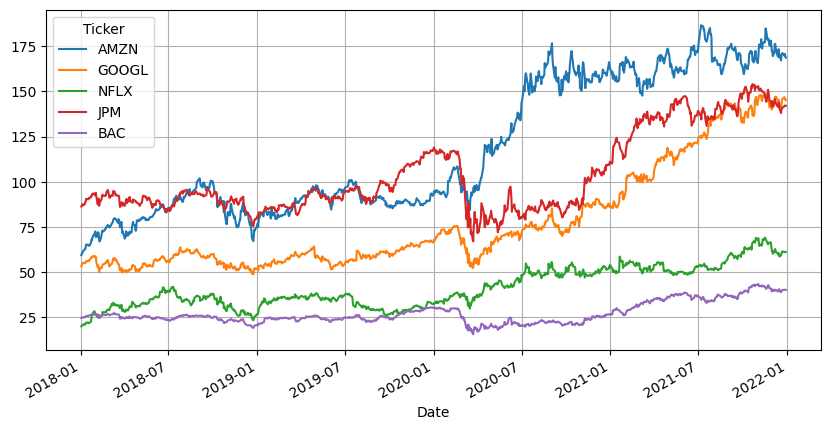

In [11]:
prices.plot(figsize=(10,5))
plt.grid()
plt.show()

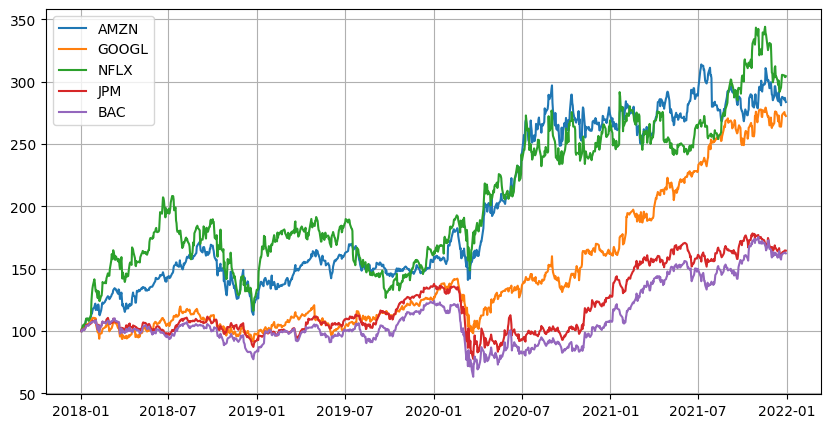

In [12]:
plt.figure(figsize=(10,5))
plt.plot(prices/prices.iloc[0]*100)
plt.legend(prices.columns)
plt.grid()
plt.show()

In [13]:
returns,mu,cov=moments(prices)

In [15]:
returns.head()

Ticker,AMZN,GOOGL,NFLX,JPM,BAC
Date,,,,,
2018-01-03,0.012775,0.017061,0.019794,0.001019,-0.003344
2018-01-04,0.004476,0.003884,0.002829,0.014326,0.013088
2018-01-05,0.016163,0.013260,0.021203,-0.006420,0.004637
2018-01-08,0.014425,0.003531,0.009810,0.001477,-0.006924
2018-01-09,0.004676,-0.001274,-0.012921,0.005069,0.004980


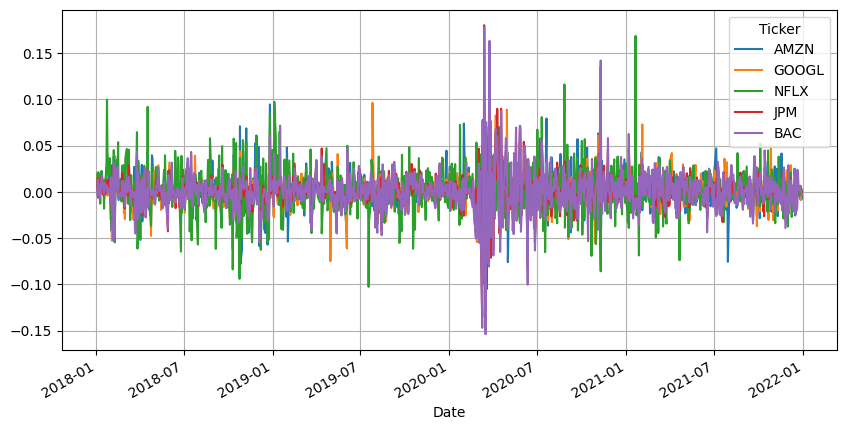

In [17]:
returns.plot(figsize=(10,5))
plt.grid()
plt.show()

In [16]:
vars=np.diag(cov)
stds=np.sqrt(vars)

/tmp/ipython-input-1686505531.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt,(stds[i],mu[i]))


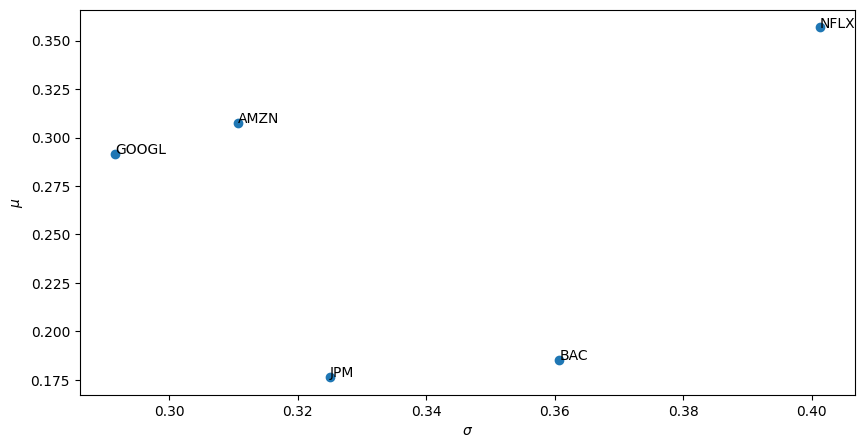

In [18]:
fig,ax=plt.subplots(figsize=(10,5))
ax.scatter(stds,mu)
for i,txt in enumerate(tickers):
    ax.annotate(txt,(stds[i],mu[i]))

plt.xlabel(r"$\sigma$", fontsize=10)
plt.ylabel(r"$\mu$", fontsize=10)

plt.show()

In [24]:
np.random.seed(100)
N=len(tickers)
weights=np.random.random(N)
weights=weights/weights.sum()
weights

array([0.25928444, 0.13282332, 0.20255761, 0.40308303, 0.00225159])

In [25]:
print(ptf_stats(weights,mu,cov,rf))

(np.float64(0.2622723321879512), np.float64(0.06325838477397837), np.float64(0.25151219607402414), np.float64(0.9997233697447108))


In [33]:
prices_traninig=prices['2018-1-1':'2021-6-30']
prices_testing=prices['2021-7-1':]
rf_series_traninig=rf_series['2018-1-1':'2021-6-30']
rf_series_testing=rf_series['2021-7-1':]

In [34]:
returns_traninig,mu_traninig,cov_traninig=moments(prices_traninig)
returns_testing,mu_testing,cov_testing=moments(prices_testing)
rf_traninig=rf_series_traninig['^IRX'].mean()
rf_testing=rf_series_testing['^IRX'].mean()

In [42]:
w_naive=np.ones(shape=len(tickers))/len(tickers)
w_minvar=optimalportfolio(cov_traninig)
w_maxsharpe=optimalportfolio(cov_traninig,mu_traninig,2,False)

In [46]:
w_naive_stats=ptf_stats(w_naive,mu_traninig,cov_traninig,rf_traninig)
w_minvar_stats=ptf_stats(w_minvar,mu_traninig,cov_traninig,rf_traninig)
w_maxsharpe_stats=ptf_stats(w_maxsharpe,mu_traninig,cov_traninig,rf_traninig)

stats_training=pd.DataFrame([w_naive_stats,w_minvar_stats,w_maxsharpe_stats],
                            columns=['Exp ret','Var','SR'],
                            index=['Naive','Minvar','Maxsharpe'])
stats_training

,Exp ret,Var,SR
Naive,0.273515,0.071767,0.974950
Minvar,0.276413,0.066705,1.022486
Maxsharpe,0.308927,0.075775,1.077459


<Axes: >

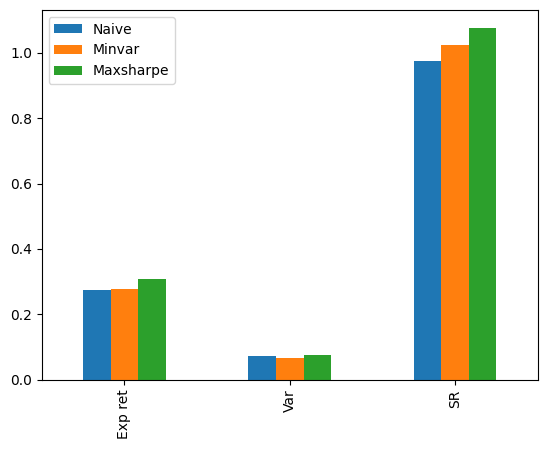

In [51]:
stats_training.T.plot(kind='bar')